In [1]:

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from gaze_rs.new_torch_retinaface import (
    RetinafaceModel,
    load_weights,
    load_bn,
    load_conv2d,
    preprocess_image,
)

from retinaface.commons.preprocess import get_image
from retinaface.commons import postprocess

In [2]:
img = get_image("../1200px-Brad_Pitt-69858.jpg")
img_tensor, im_info, im_scale = preprocess_image(img, allow_upscaling=True)

In [11]:
model = RetinafaceModel()
model.eval()
dummy_input = torch.randn(1, 3, 224, 224)

with torch.no_grad():
    _output = model(torch.from_numpy(img_tensor.astype(np.float32)))
    _output = [_.numpy() for _ in _output]

In [71]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_anchor_centers(feat_shape, stride):
    h, w = feat_shape
    y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    # Each anchor is centered at (x + 0.5, y + 0.5) * stride
    centers = np.stack([(x + 0.5) * stride, (y + 0.5) * stride], axis=-1)
    return centers  # shape: (h, w, 2)

def decode_bbox(anchor_center, bbox_delta):
    dx, dy, dw, dh = bbox_delta
    px, py = anchor_center
    # Simplified decoding logic
    w = np.exp(dw)
    h = np.exp(dh)
    cx = dx + px
    cy = dy + py
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return [x1, y1, x2, y2]

def find_best_face_box(cls_probs, bbox_preds, strides=[32, 16, 8]):
    best_score = -np.inf
    best_box = None

    for i in range(3):
        stride = strides[i]
        
        cls = sigmoid(cls_probs[i][0])  # shape: (num_anchors, H, W)
        bbox = bbox_preds[i][0]         # shape: (num_anchors * 4, H, W)

        num_anchors = cls.shape[0]
        H, W = cls.shape[1], cls.shape[2]

        # Reshape bbox to (num_anchors, 4, H, W)
        C, H, W = bbox.shape
        num_anchors = C // 4
        bbox = bbox.reshape(num_anchors, 4, H, W)

        # Generate anchor centers
        centers = generate_anchor_centers((H, W), stride)  # shape: (H, W, 2)

        for anchor_idx in range(num_anchors):
            cls_anchor = cls[anchor_idx]        # shape: (H, W)
            bbox_anchor = bbox[anchor_idx]      # shape: (4, H, W)

            idx = np.unravel_index(np.argmax(cls_anchor), cls_anchor.shape)
            score = cls_anchor[idx]
            anchor_center = centers[idx]
            bbox_delta = bbox_anchor[:, idx[0], idx[1]]
            box = decode_bbox(anchor_center, bbox_delta)

            if score > best_score:
                best_score = score
                best_box = box

    return best_box  # [x1, y1, x2, y2]


In [72]:
cls_probs = [_output[0], _output[3], _output[6]]
bbox_preds = [_output[1], _output[4], _output[7]]
find_best_face_box(cls_probs, bbox_preds)

[np.float64(975.5428423695266),
 np.float64(335.3982652425766),
 np.float64(976.5387149266899),
 np.float64(336.43571078777313)]

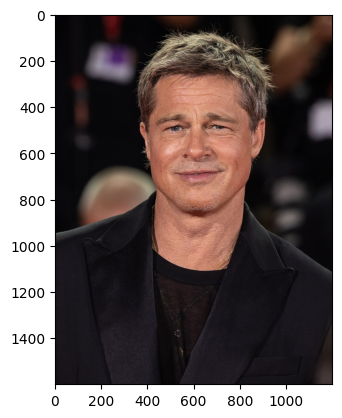

In [74]:
plt.imshow(img[::,::,::-1])

In [14]:
def uwu(output: list[np.ndarray], im_info: tuple[int,int], im_scale, threshold: float=.9):
    resp = {}
    nms_threshold = 0.4
    decay4 = 0.5
    _feat_stride_fpn = [32, 16, 8]
    _anchors_fpn = {
        "stride32": np.array(
            [[-248.0, -248.0, 263.0, 263.0], [-120.0, -120.0, 135.0, 135.0]], dtype=np.float32
        ),
        "stride16": np.array(
            [[-56.0, -56.0, 71.0, 71.0], [-24.0, -24.0, 39.0, 39.0]], dtype=np.float32
        ),
        "stride8": np.array([[-8.0, -8.0, 23.0, 23.0], [0.0, 0.0, 15.0, 15.0]], dtype=np.float32),
    }
    _num_anchors = {"stride32": 2, "stride16": 2, "stride8": 2}
    proposals_list = []
    scores_list = []
    landmarks_list = []
    net_out = output
    sym_idx = 0
    for _, s in enumerate(_feat_stride_fpn):
        # _key = f"stride{s}"
        scores = net_out[sym_idx]
        scores = scores[:, :, :, _num_anchors[f"stride{s}"] :]

        bbox_deltas = net_out[sym_idx + 1]
        height, width = bbox_deltas.shape[1], bbox_deltas.shape[2]

        A = _num_anchors[f"stride{s}"]
        K = height * width
        anchors_fpn = _anchors_fpn[f"stride{s}"]
        anchors = postprocess.anchors_plane(height, width, s, anchors_fpn)
        anchors = anchors.reshape((K * A, 4))
        scores = scores.reshape((-1, 1))

        bbox_stds = [1.0, 1.0, 1.0, 1.0]
        bbox_pred_len = bbox_deltas.shape[3] // A
        bbox_deltas = bbox_deltas.reshape((-1, bbox_pred_len))
        bbox_deltas[:, 0::4] = bbox_deltas[:, 0::4] * bbox_stds[0]
        bbox_deltas[:, 1::4] = bbox_deltas[:, 1::4] * bbox_stds[1]
        bbox_deltas[:, 2::4] = bbox_deltas[:, 2::4] * bbox_stds[2]
        bbox_deltas[:, 3::4] = bbox_deltas[:, 3::4] * bbox_stds[3]
        proposals = postprocess.bbox_pred(anchors, bbox_deltas)

        proposals = postprocess.clip_boxes(proposals, im_info[:2])

        if s == 4 and decay4 < 1.0:
            scores *= decay4

        scores_ravel = scores.ravel()
        order = np.where(scores_ravel >= threshold)[0]
        proposals = proposals[order, :]
        scores = scores[order]

        proposals[:, 0:4] /= im_scale
        proposals_list.append(proposals)
        scores_list.append(scores)

        # landmark_deltas = net_out[sym_idx + 2]
        # landmark_pred_len = landmark_deltas.shape[3] // A
        # landmark_deltas = landmark_deltas.reshape((-1, 5, landmark_pred_len // 5))
        # landmarks = postprocess.landmark_pred(anchors, landmark_deltas)
        # landmarks = landmarks[order, :]

        # landmarks[:, :, 0:2] /= im_scale
        # landmarks_list.append(landmarks)
        sym_idx += 3

    proposals = np.vstack(proposals_list)

    if proposals.shape[0] == 0:
        return resp

    scores = np.vstack(scores_list)
    scores_ravel = scores.ravel()
    order = scores_ravel.argsort()[::-1]

    proposals = proposals[order, :]
    scores = scores[order]
    # landmarks = np.vstack(landmarks_list)
    # landmarks = landmarks[order].astype(np.float32, copy=False)

    pre_det = np.hstack((proposals[:, 0:4], scores)).astype(np.float32, copy=False)

    # nms = cpu_nms_wrapper(nms_threshold)
    # keep = nms(pre_det)
    keep = postprocess.cpu_nms(pre_det, nms_threshold)

    det = np.hstack((pre_det, proposals[:, 4:]))
    det = det[keep, :]
    # landmarks = landmarks[keep]

    for idx, face in enumerate(det):
        label = "face_" + str(idx + 1)
        resp[label] = {}
        resp[label]["score"] = face[4]
        resp[label]["facial_area"] = list(face[0:4].astype(int))
        # resp[label]["landmarks"] = {}
        # resp[label]["landmarks"]["right_eye"] = list(landmarks[idx][0])
        # resp[label]["landmarks"]["left_eye"] = list(landmarks[idx][1])
        # resp[label]["landmarks"]["nose"] = list(landmarks[idx][2])
        # resp[label]["landmarks"]["mouth_right"] = list(landmarks[idx][3])
        # resp[label]["landmarks"]["mouth_left"] = list(landmarks[idx][4])

    return resp

In [38]:
res = uwu(output, im_info, im_scale, .6)
bbox = res["face_1"]["facial_area"]
x1, y1, x2, y2 = bbox
x1, y1, x2, y2

(np.int64(581), np.int64(820), np.int64(873), np.int64(1175))

In [44]:
w,h = im_info
w,h

(1365, 1024)

In [59]:
h-x1, h-x2

(np.int64(443), np.int64(151))

In [ ]:
h-y2, h

(1024, np.int64(1175))

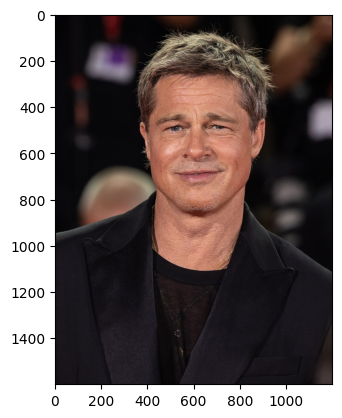

In [55]:
plt.imshow(img[::,::,::-1])

In [ ]:
nms_threshold = 0.4
decay4 = 0.5
_feat_stride_fpn = [32, 16, 8]
_anchors_fpn = {
    "stride32": np.array(
        [[-248.0, -248.0, 263.0, 263.0], [-120.0, -120.0, 135.0, 135.0]], dtype=np.float32
    ),
    "stride16": np.array(
        [[-56.0, -56.0, 71.0, 71.0], [-24.0, -24.0, 39.0, 39.0]], dtype=np.float32
    ),
    "stride8": np.array([[-8.0, -8.0, 23.0, 23.0], [0.0, 0.0, 15.0, 15.0]], dtype=np.float32),
}
sym_idx = 0
_num_anchors = {"stride32": 2, "stride16": 2, "stride8": 2}

for _, s in enumerate(_feat_stride_fpn):
    scores = output[sym_idx+1]
    scores = scores[:, :, :, 2:]

    bbox_deltas = output[sym_idx]
    height, width = bbox_deltas.shape[1], bbox_deltas.shape[2]

    A = 2
    K = height * width
    anchors_fpn = _anchors_fpn[f"stride{s}"]
    anchors = postprocess.anchors_plane(height, width, s, anchors_fpn)
    anchors = anchors.reshape((K * A, 4))
    scores = scores.reshape((-1, 1))

    sym_idx += 3

In [ ]:
width

In [ ]:
import h5py

f = h5py.File('../retinaface.h5', 'r')

def print_h5_structure(group, indent=0):
    """
    Recursively print the structure of an HDF5 file (groups and datasets).
    
    :param group: Current HDF5 group or dataset.
    :param indent: Current indentation level for pretty printing.
    """
    # Print the name of the group or dataset
    print('  ' * indent + f'{group.name}')
    
    # If it's a group, recursively print its items
    if isinstance(group, h5py.Group):
        for name, item in group.items():
            print_h5_structure(item, indent + 1)  # Recurse into the items
    else:
        # If it's a dataset, print its shape and data type
        print('  ' * (indent + 1) + f'Shape: {group.shape}')
        print('  ' * (indent + 1) + f'Data type: {group.dtype}')


print_h5_structure(f)

In [ ]:
list(f["bn0/bn0"].keys())

In [ ]:
def load_bn(torch_bn: nn.BatchNorm2d, keras_group: h5py.Group) -> None:
    with torch.no_grad():
        torch_bn.weight.copy_(torch.tensor(keras_group["gamma:0"][:]))
        torch_bn.bias.copy_(torch.tensor(keras_group["beta:0"][:]))
        torch_bn.running_mean.copy_(torch.tensor(keras_group["moving_mean:0"][:]))
        torch_bn.running_var.copy_(torch.tensor(keras_group["moving_variance:0"][:]))


def load_conv2d(torch_conv: nn.Conv2d, keras_group: h5py.Group, bias: bool=False) -> None:
    with torch.no_grad():
        keras_weights = keras_group["kernel:0"][:]  # shape: (kh, kw, in_c, out_c)
        keras_weights = np.transpose(keras_weights, (3, 2, 0, 1))      # to (out_c, in_c, kh, kw)
        torch_conv.weight.copy_(torch.tensor(keras_weights))
        if bias:
            torch_conv.bias.copy_(torch.tensor(keras_group["bias:0"][:]))


In [ ]:
model = RetinafaceModel()

# stage0
load_bn(model.bn0, f["bn0/bn0"])
load_bn(model.bn_data, f["bn_data/bn_data"])
load_conv2d(model.conv0, f["conv0/conv0"])
# stage1
# stage1_unit1
load_bn(model.stage1_unit1_bn1, f["stage1_unit1_bn1/stage1_unit1_bn1"])
load_conv2d(model.stage1_unit1_conv1, f["stage1_unit1_conv1/stage1_unit1_conv1"])
load_bn(model.stage1_unit1_bn2, f["stage1_unit1_bn2/stage1_unit1_bn2"])
load_conv2d(model.stage1_unit1_conv2, f["stage1_unit1_conv2/stage1_unit1_conv2"])
load_bn(model.stage1_unit1_bn3, f["stage1_unit1_bn3/stage1_unit1_bn3"])
load_conv2d(model.stage1_unit1_conv3, f["stage1_unit1_conv3/stage1_unit1_conv3"])
## stage1_unit2
load_bn(model.stage1_unit2_bn1, f["stage1_unit2_bn1/stage1_unit2_bn1"])
load_conv2d(model.stage1_unit2_conv1, f["stage1_unit2_conv1/stage1_unit2_conv1"])
load_bn(model.stage1_unit2_bn2, f["stage1_unit2_bn2/stage1_unit2_bn2"])
load_conv2d(model.stage1_unit2_conv2, f["stage1_unit2_conv2/stage1_unit2_conv2"])
load_bn(model.stage1_unit2_bn3, f["stage1_unit2_bn3/stage1_unit2_bn3"])
load_conv2d(model.stage1_unit2_conv3, f["stage1_unit2_conv3/stage1_unit2_conv3"])
## stage1_unit3
load_bn(model.stage1_unit3_bn1, f["stage1_unit3_bn1/stage1_unit3_bn1"])
load_conv2d(model.stage1_unit3_conv1, f["stage1_unit3_conv1/stage1_unit3_conv1"])
load_bn(model.stage1_unit3_bn2, f["stage1_unit3_bn2/stage1_unit3_bn2"])
load_conv2d(model.stage1_unit3_conv2, f["stage1_unit3_conv2/stage1_unit3_conv2"])
load_bn(model.stage1_unit3_bn3, f["stage1_unit3_bn3/stage1_unit3_bn3"])
load_conv2d(model.stage1_unit3_conv3, f["stage1_unit3_conv3/stage1_unit3_conv3"])
# stage2
## stage2_unit1
load_bn(model.stage2_unit1_bn1, f["stage2_unit1_bn1/stage2_unit1_bn1"])
load_conv2d(model.stage2_unit1_conv1, f["stage2_unit1_conv1/stage2_unit1_conv1"])
load_bn(model.stage2_unit1_bn2, f["stage2_unit1_bn2/stage2_unit1_bn2"])
load_conv2d(model.stage2_unit1_conv2, f["stage2_unit1_conv2/stage2_unit1_conv2"])
load_bn(model.stage2_unit1_bn3, f["stage2_unit1_bn3/stage2_unit1_bn3"])
load_conv2d(model.stage2_unit1_conv3, f["stage2_unit1_conv3/stage2_unit1_conv3"])
load_conv2d(model.stage2_unit1_sc, f["stage2_unit1_sc/stage2_unit1_sc"])
## stage2_unit2
load_bn(model.stage2_unit2_bn1, f["stage2_unit2_bn1/stage2_unit2_bn1"])
load_conv2d(model.stage2_unit2_conv1, f["stage2_unit2_conv1/stage2_unit2_conv1"])
load_bn(model.stage2_unit2_bn2, f["stage2_unit2_bn2/stage2_unit2_bn2"])
load_conv2d(model.stage2_unit2_conv2, f["stage2_unit2_conv2/stage2_unit2_conv2"])
load_bn(model.stage2_unit2_bn3, f["stage2_unit2_bn3/stage2_unit2_bn3"])
load_conv2d(model.stage2_unit2_conv3, f["stage2_unit2_conv3/stage2_unit2_conv3"])
## stage2_unit3
load_bn(model.stage2_unit3_bn1, f["stage2_unit3_bn1/stage2_unit3_bn1"])
load_conv2d(model.stage2_unit3_conv1, f["stage2_unit3_conv1/stage2_unit3_conv1"])
load_bn(model.stage2_unit3_bn2, f["stage2_unit3_bn2/stage2_unit3_bn2"])
load_conv2d(model.stage2_unit3_conv2, f["stage2_unit3_conv2/stage2_unit3_conv2"])
load_bn(model.stage2_unit3_bn3, f["stage2_unit3_bn3/stage2_unit3_bn3"])
load_conv2d(model.stage2_unit3_conv3, f["stage2_unit3_conv3/stage2_unit3_conv3"])
## stage2_unit4
load_bn(model.stage2_unit4_bn1, f["stage2_unit4_bn1/stage2_unit4_bn1"])
load_conv2d(model.stage2_unit4_conv1, f["stage2_unit4_conv1/stage2_unit4_conv1"])
load_bn(model.stage2_unit4_bn2, f["stage2_unit4_bn2/stage2_unit4_bn2"])
load_conv2d(model.stage2_unit4_conv2, f["stage2_unit4_conv2/stage2_unit4_conv2"])
load_bn(model.stage2_unit4_bn3, f["stage2_unit4_bn3/stage2_unit4_bn3"])
load_conv2d(model.stage2_unit4_conv3, f["stage2_unit4_conv3/stage2_unit4_conv3"])
# stage3
## stage3_unit1
load_bn(model.stage3_unit1_bn1, f["stage3_unit1_bn1/stage3_unit1_bn1"])
load_conv2d(model.stage3_unit1_conv1, f["stage3_unit1_conv1/stage3_unit1_conv1"])
load_bn(model.stage3_unit1_bn2, f["stage3_unit1_bn2/stage3_unit1_bn2"])
load_conv2d(model.stage3_unit1_conv2, f["stage3_unit1_conv2/stage3_unit1_conv2"])
load_bn(model.stage3_unit1_bn3, f["stage3_unit1_bn3/stage3_unit1_bn3"])
load_conv2d(model.stage3_unit1_conv3, f["stage3_unit1_conv3/stage3_unit1_conv3"])
load_conv2d(model.stage3_unit1_sc, f["stage3_unit1_sc/stage3_unit1_sc"])
## stage3_unit2
load_bn(model.stage3_unit2_bn1, f["stage3_unit2_bn1/stage3_unit2_bn1"])
load_conv2d(model.stage3_unit2_conv1, f["stage3_unit2_conv1/stage3_unit2_conv1"])
load_bn(model.stage3_unit2_bn2, f["stage3_unit2_bn2/stage3_unit2_bn2"])
load_conv2d(model.stage3_unit2_conv2, f["stage3_unit2_conv2/stage3_unit2_conv2"])
load_bn(model.stage3_unit2_bn3, f["stage3_unit2_bn3/stage3_unit2_bn3"])
load_conv2d(model.stage3_unit2_conv3, f["stage3_unit2_conv3/stage3_unit2_conv3"])
## stage3_unit3
load_bn(model.stage3_unit3_bn1, f["stage3_unit3_bn1/stage3_unit3_bn1"])
load_conv2d(model.stage3_unit3_conv1, f["stage3_unit3_conv1/stage3_unit3_conv1"])
load_bn(model.stage3_unit3_bn2, f["stage3_unit3_bn2/stage3_unit3_bn2"])
load_conv2d(model.stage3_unit3_conv2, f["stage3_unit3_conv2/stage3_unit3_conv2"])
load_bn(model.stage3_unit3_bn3, f["stage3_unit3_bn3/stage3_unit3_bn3"])
load_conv2d(model.stage3_unit3_conv3, f["stage3_unit3_conv3/stage3_unit3_conv3"])
## stage3_unit4
load_bn(model.stage3_unit4_bn1, f["stage3_unit4_bn1/stage3_unit4_bn1"])
load_conv2d(model.stage3_unit4_conv1, f["stage3_unit4_conv1/stage3_unit4_conv1"])
load_bn(model.stage3_unit4_bn2, f["stage3_unit4_bn2/stage3_unit4_bn2"])
load_conv2d(model.stage3_unit4_conv2, f["stage3_unit4_conv2/stage3_unit4_conv2"])
load_bn(model.stage3_unit4_bn3, f["stage3_unit4_bn3/stage3_unit4_bn3"])
load_conv2d(model.stage3_unit4_conv3, f["stage3_unit4_conv3/stage3_unit4_conv3"])
## stage3_unit5
load_bn(model.stage3_unit5_bn1, f["stage3_unit5_bn1/stage3_unit5_bn1"])
load_conv2d(model.stage3_unit5_conv1, f["stage3_unit5_conv1/stage3_unit5_conv1"])
load_bn(model.stage3_unit5_bn2, f["stage3_unit5_bn2/stage3_unit5_bn2"])
load_conv2d(model.stage3_unit5_conv2, f["stage3_unit5_conv2/stage3_unit5_conv2"])
load_bn(model.stage3_unit5_bn3, f["stage3_unit5_bn3/stage3_unit5_bn3"])
load_conv2d(model.stage3_unit5_conv3, f["stage3_unit5_conv3/stage3_unit5_conv3"])
## stage3_unit6
load_bn(model.stage3_unit6_bn1, f["stage3_unit6_bn1/stage3_unit6_bn1"])
load_conv2d(model.stage3_unit6_conv1, f["stage3_unit6_conv1/stage3_unit6_conv1"])
load_bn(model.stage3_unit6_bn2, f["stage3_unit6_bn2/stage3_unit6_bn2"])
load_conv2d(model.stage3_unit6_conv2, f["stage3_unit6_conv2/stage3_unit6_conv2"])
load_bn(model.stage3_unit6_bn3, f["stage3_unit6_bn3/stage3_unit6_bn3"])
load_conv2d(model.stage3_unit6_conv3, f["stage3_unit6_conv3/stage3_unit6_conv3"])
# stage4
## stage4_unit1
load_bn(model.stage4_unit1_bn1, f["stage4_unit1_bn1/stage4_unit1_bn1"])
load_conv2d(model.stage4_unit1_conv1, f["stage4_unit1_conv1/stage4_unit1_conv1"])
load_bn(model.stage4_unit1_bn2, f["stage4_unit1_bn2/stage4_unit1_bn2"])
load_conv2d(model.stage4_unit1_conv2, f["stage4_unit1_conv2/stage4_unit1_conv2"])
load_bn(model.stage4_unit1_bn3, f["stage4_unit1_bn3/stage4_unit1_bn3"])
load_conv2d(model.stage4_unit1_conv3, f["stage4_unit1_conv3/stage4_unit1_conv3"])
load_conv2d(model.stage4_unit1_sc, f["stage4_unit1_sc/stage4_unit1_sc"])
## stage4_unit2
load_bn(model.stage4_unit2_bn1, f["stage4_unit2_bn1/stage4_unit2_bn1"])
load_conv2d(model.stage4_unit2_conv1, f["stage4_unit2_conv1/stage4_unit2_conv1"])
load_bn(model.stage4_unit2_bn2, f["stage4_unit2_bn2/stage4_unit2_bn2"])
load_conv2d(model.stage4_unit2_conv2, f["stage4_unit2_conv2/stage4_unit2_conv2"])
load_bn(model.stage4_unit2_bn3, f["stage4_unit2_bn3/stage4_unit2_bn3"])
load_conv2d(model.stage4_unit2_conv3, f["stage4_unit2_conv3/stage4_unit2_conv3"])
## stage4_unit3
load_bn(model.stage4_unit3_bn1, f["stage4_unit3_bn1/stage4_unit3_bn1"])
load_conv2d(model.stage4_unit3_conv1, f["stage4_unit3_conv1/stage4_unit3_conv1"])
load_bn(model.stage4_unit3_bn2, f["stage4_unit3_bn2/stage4_unit3_bn2"])
load_conv2d(model.stage4_unit3_conv2, f["stage4_unit3_conv2/stage4_unit3_conv2"])
load_bn(model.stage4_unit3_bn3, f["stage4_unit3_bn3/stage4_unit3_bn3"])
load_conv2d(model.stage4_unit3_conv3, f["stage4_unit3_conv3/stage4_unit3_conv3"])
# ssh_1
load_conv2d(model.ssh_m1_red_conv, f["ssh_m1_red_conv/ssh_m1_red_conv"], bias=True)
load_bn(model.ssh_m1_red_conv_bn, f["ssh_m1_red_conv_bn/ssh_m1_red_conv_bn"])
##
load_conv2d(model.ssh_c1_aggr, f["ssh_c1_aggr/ssh_c1_aggr"], bias=True)
load_bn(model.ssh_c1_aggr_bn, f["ssh_c1_aggr_bn/ssh_c1_aggr_bn"])
load_conv2d(model.ssh_m1_det_context_conv1, f["ssh_m1_det_context_conv1/ssh_m1_det_context_conv1"], bias=True)
load_bn(model.ssh_m1_det_context_conv1_bn, f["ssh_m1_det_context_conv1_bn/ssh_m1_det_context_conv1_bn"])
##
load_conv2d(model.ssh_m1_det_context_conv3_1, f["ssh_m1_det_context_conv3_1/ssh_m1_det_context_conv3_1"], bias=True)
load_bn(model.ssh_m1_det_context_conv3_1_bn, f["ssh_m1_det_context_conv3_1_bn/ssh_m1_det_context_conv3_1_bn"])
load_conv2d(model.ssh_m1_det_context_conv3_2, f["ssh_m1_det_context_conv3_2/ssh_m1_det_context_conv3_2"], bias=True)
load_bn(model.ssh_m1_det_context_conv3_2_bn, f["ssh_m1_det_context_conv3_2_bn/ssh_m1_det_context_conv3_2_bn"])
##
load_conv2d(model.ssh_m1_det_context_conv2, f["ssh_m1_det_context_conv2/ssh_m1_det_context_conv2"], bias=True)
load_bn(model.ssh_m1_det_context_conv2_bn, f["ssh_m1_det_context_conv2_bn/ssh_m1_det_context_conv2_bn"])
##
load_conv2d(model.ssh_m1_det_conv1, f["ssh_m1_det_conv1/ssh_m1_det_conv1"], bias=True)
load_bn(model.ssh_m1_det_conv1_bn, f["ssh_m1_det_conv1_bn/ssh_m1_det_conv1_bn"])
# ssh_2
load_conv2d(model.ssh_c2_lateral, f["ssh_c2_lateral/ssh_c2_lateral"], bias=True)
load_bn(model.ssh_c2_lateral_bn, f["ssh_c2_lateral_bn/ssh_c2_lateral_bn"])
##
load_conv2d(model.ssh_c2_aggr, f["ssh_c2_aggr/ssh_c2_aggr"], bias=True)
load_bn(model.ssh_c2_aggr_bn, f["ssh_c2_aggr_bn/ssh_c2_aggr_bn"])
load_conv2d(model.ssh_m2_det_context_conv1, f["ssh_m2_det_context_conv1/ssh_m2_det_context_conv1"], bias=True)
load_bn(model.ssh_m2_det_context_conv1_bn, f["ssh_m2_det_context_conv1_bn/ssh_m2_det_context_conv1_bn"])
##
load_conv2d(model.ssh_m2_det_context_conv3_1, f["ssh_m2_det_context_conv3_1/ssh_m2_det_context_conv3_1"], bias=True)
load_bn(model.ssh_m2_det_context_conv3_1_bn, f["ssh_m2_det_context_conv3_1_bn/ssh_m2_det_context_conv3_1_bn"])
load_conv2d(model.ssh_m2_det_context_conv3_2, f["ssh_m2_det_context_conv3_2/ssh_m2_det_context_conv3_2"], bias=True)
load_bn(model.ssh_m2_det_context_conv3_2_bn, f["ssh_m2_det_context_conv3_2_bn/ssh_m2_det_context_conv3_2_bn"])
##
load_conv2d(model.ssh_m2_det_context_conv2, f["ssh_m2_det_context_conv2/ssh_m2_det_context_conv2"], bias=True)
load_bn(model.ssh_m2_det_context_conv2_bn, f["ssh_m2_det_context_conv2_bn/ssh_m2_det_context_conv2_bn"])
##
load_conv2d(model.ssh_m2_det_conv1, f["ssh_m2_det_conv1/ssh_m2_det_conv1"], bias=True)
load_bn(model.ssh_m2_det_conv1_bn, f["ssh_m2_det_conv1_bn/ssh_m2_det_conv1_bn"])
# ssh_3
load_bn(model.bn1, f["bn1/bn1"])
##
load_conv2d(model.ssh_c3_lateral, f["ssh_c3_lateral/ssh_c3_lateral"], bias=True)
load_bn(model.ssh_c3_lateral_bn, f["ssh_c3_lateral_bn/ssh_c3_lateral_bn"])
##
load_conv2d(model.ssh_m3_det_context_conv3_1, f["ssh_m3_det_context_conv3_1/ssh_m3_det_context_conv3_1"], bias=True)
load_bn(model.ssh_m3_det_context_conv3_1_bn, f["ssh_m3_det_context_conv3_1_bn/ssh_m3_det_context_conv3_1_bn"])
load_conv2d(model.ssh_m3_det_context_conv3_2, f["ssh_m3_det_context_conv3_2/ssh_m3_det_context_conv3_2"], bias=True)
load_bn(model.ssh_m3_det_context_conv3_2_bn, f["ssh_m3_det_context_conv3_2_bn/ssh_m3_det_context_conv3_2_bn"])
##
load_conv2d(model.ssh_m3_det_context_conv2, f["ssh_m3_det_context_conv2/ssh_m3_det_context_conv2"], bias=True)
load_bn(model.ssh_m3_det_context_conv2_bn, f["ssh_m3_det_context_conv2_bn/ssh_m3_det_context_conv2_bn"])
##
load_conv2d(model.ssh_m3_det_conv1, f["ssh_m3_det_conv1/ssh_m3_det_conv1"], bias=True)
load_bn(model.ssh_m3_det_conv1_bn, f["ssh_m3_det_conv1_bn/ssh_m3_det_conv1_bn"])
# stride8
load_conv2d(model.face_rpn_bbox_pred_stride8, f["face_rpn_bbox_pred_stride8/face_rpn_bbox_pred_stride8"], bias=True)
load_conv2d(model.face_rpn_cls_score_stride8, f["face_rpn_cls_score_stride8/face_rpn_cls_score_stride8"], bias=True)
load_conv2d(model.face_rpn_landmark_pred_stride8, f["face_rpn_landmark_pred_stride8/face_rpn_landmark_pred_stride8"], bias=True)
# stride16
load_conv2d(model.face_rpn_bbox_pred_stride16, f["face_rpn_bbox_pred_stride16/face_rpn_bbox_pred_stride16"], bias=True)
load_conv2d(model.face_rpn_cls_score_stride16, f["face_rpn_cls_score_stride16/face_rpn_cls_score_stride16"], bias=True)
load_conv2d(model.face_rpn_landmark_pred_stride16, f["face_rpn_landmark_pred_stride16/face_rpn_landmark_pred_stride16"], bias=True)
# stride32
load_conv2d(model.face_rpn_bbox_pred_stride32, f["face_rpn_bbox_pred_stride32/face_rpn_bbox_pred_stride32"], bias=True)
load_conv2d(model.face_rpn_cls_score_stride32, f["face_rpn_cls_score_stride32/face_rpn_cls_score_stride32"], bias=True)
load_conv2d(model.face_rpn_landmark_pred_stride32, f["face_rpn_landmark_pred_stride32/face_rpn_landmark_pred_stride32"], bias=True)



In [ ]:
model.get_parameter("bn_data.weight")

In [ ]:
# Open the HDF5 file
with h5py.File('../retinaface.h5', 'r') as f:
    # Access the /bn0/bn0 group
    bn0_group = f["/bn0/bn0"]
    
    # Access the batch normalization parameters
    beta_bn0 = bn0_group["beta"]
    gamma_bn0 = bn0_group["gamma"]
    moving_mean_bn0 = bn0_group["moving_mean"]
    moving_variance_bn0 = bn0_group["moving_variance"]
    
    # Print their shapes and values
    print("bn0/bn0 beta shape:", beta_bn0.shape)
    print("bn0/bn0 beta data:", beta_bn0[:])  # Prints the values of beta
    print("bn0/bn0 gamma shape:", gamma_bn0.shape)
    print("bn0/bn0 gamma data:", gamma_bn0[:])  # Prints the values of gamma
    print("bn0/bn0 moving_mean shape:", moving_mean_bn0.shape)
    print("bn0/bn0 moving_mean data:", moving_mean_bn0[:])  # Prints the values of moving_mean
    print("bn0/bn0 moving_variance shape:", moving_variance_bn0.shape)
    print("bn0/bn0 moving_variance data:", moving_variance_bn0[:])  # Prints the values of moving_variance


In [ ]:
RetinaFace.build_model()

In [ ]:
RetinaFace.detect_faces("../1200px-Brad_Pitt-69858.jpg")